In [1]:
# Let's use the methods 
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, TruePositiveRateDifference
from fairlearn.metrics import selection_rate_group_summary

In [43]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from aequitas.group import Group
from aequitas.bias import Bias
import aequitas.plot as ap
import seaborn as sns
import matplotlib.pyplot as plt
#from aequitas.fairness import Fairness

sns.set()
DPI = 200
warnings.filterwarnings("ignore")

In [52]:
#testing with this data
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'
# NOTE: Exponentiated Gradient has a stoachastic component
np.random.seed(0)

evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')
# Let's sort the models by Precision at top 1000 predicted positives (our performance metric of interest for this case study)
evals_df.sort_values('model_precision', ascending = False)
aequitas_df = pd.read_csv(DATAPATH + 'split2_aequitas.csv.gz', compression='gzip')

traindf = pd.read_csv(DATAPATH + 'train_20120501_20120801.csv.gz', compression='gzip')
testdf = pd.read_csv(DATAPATH + 'test_20121201_20130201.csv.gz', compression='gzip')
train_attrdf = pd.read_csv(DATAPATH + 'train_20120501_20120801_protected.csv.gz', compression='gzip')
test_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

label_col = 'quickstart_label'
date_col = 'as_of_date'
id_col = 'entity_id'
attr_col = 'poverty_level'
exclude_cols = [label_col, date_col, id_col]

top_k = 1000

# aequitas parameters
metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {attr_col:'lower'}


X_train, y_train, A_train = traindf[[c for c in traindf.columns if c not in exclude_cols]].values, traindf[label_col].values, train_attrdf[[attr_col]]
X_test,   y_test,   A_test   = testdf[[c for c in testdf.columns if c not in exclude_cols]].values,   testdf[label_col].values  , test_attrdf[[attr_col]]


In [76]:
train_attrdf.head(2)


,entity_id,as_of_date,poverty_level,teacher_sex,metro_type
0,251733,1335913200000,highest,female,suburban_rural
1,251734,1335913200000,lower,male,suburban_rural


In [54]:
traindf.head(2)

,entity_id,as_of_date,project_features_entity_id_all_grade_level_Grades35_sum,project_features_entity_id_all_grade_level_Grades68_sum,project_features_entity_id_all_grade_level_Grades912_sum,project_features_entity_id_all_grade_level_GradesPreK2_sum,project_features_entity_id_all_grade_level__NULL_sum,project_features_entity_id_all_resource_type_Books_sum,project_features_entity_id_all_resource_type_Other_sum,project_features_entity_id_all_resource_type_Supplies_sum,...,donation_features_entity_id_all_zip_avg_donations_2yr_imp,donation_features_entity_id_all_zip_funding_rate_1yr_sum,donation_features_entity_id_all_zip_funding_rate_1yr_imp,donation_features_entity_id_all_zip_funding_rate_2yr_sum,donation_features_entity_id_all_zip_funding_rate_2yr_imp,quickstart_label,project_features_entity_id_all_poverty_level_highpoverty,project_features_entity_id_all_poverty_level_highestpoverty,project_features_entity_id_all_poverty_level_lowpoverty,project_features_entity_id_all_poverty_level_moderatepoverty
0,251733,1335913200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.588235,0.0,0.619048,0.0,0.0,0.0,1.0,0.0,0.0
1,251734,1335913200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.927536,0.0,0.785714,0.0,0.0,0.0,0.0,1.0,0.0


In [68]:
traindf.shape

(16790, 113)

In [67]:
len(traindf[label_col].values)

16790

In [62]:
traindf.columns

Index(['entity_id', 'as_of_date',
       'project_features_entity_id_all_grade_level_Grades35_sum',
       'project_features_entity_id_all_grade_level_Grades68_sum',
       'project_features_entity_id_all_grade_level_Grades912_sum',
       'project_features_entity_id_all_grade_level_GradesPreK2_sum',
       'project_features_entity_id_all_grade_level__NULL_sum',
       'project_features_entity_id_all_resource_type_Books_sum',
       'project_features_entity_id_all_resource_type_Other_sum',
       'project_features_entity_id_all_resource_type_Supplies_sum',
       ...
       'donation_features_entity_id_all_zip_avg_donations_2yr_imp',
       'donation_features_entity_id_all_zip_funding_rate_1yr_sum',
       'donation_features_entity_id_all_zip_funding_rate_1yr_imp',
       'donation_features_entity_id_all_zip_funding_rate_2yr_sum',
       'donation_features_entity_id_all_zip_funding_rate_2yr_imp',
       'quickstart_label',
       'project_features_entity_id_all_poverty_level_highpovert

In [55]:
exclude_cols

['quickstart_label', 'as_of_date', 'entity_id']

In [72]:
X_train.shape, type(X_train)

((16790, 110), numpy.ndarray)

In [73]:
y_train.shape, type(y_train)

((16790,), numpy.ndarray)

In [70]:
train_attrdf[[attr_col]]

,poverty_level
0,highest
1,lower
2,highest
3,highest
4,lower
...,...
16785,highest
16786,highest
16787,highest
16788,highest


In [74]:
A_train.shape, type(A_train)

((16790, 1), pandas.core.frame.DataFrame)

In [ ]:
#NICE TO HAVE BELOW 

In [29]:
#function to plot tpr disparity against precision
def create_scatter_disparity_performance(evals_df, aequitas_df,  attr_col, group_name, 
                                         performance_col='model_precision', bias_metric='tpr', flip_disparity=False, 
                                         mitigated_tags=[], mitigated_bdfs=[], mitigated_performances=[], ylim=None):
    disparity_df = aequitas_df.loc[(aequitas_df['attribute_name']==attr_col) & (aequitas_df['attribute_value']==group_name)].copy()
    disparity_metric = bias_metric + '_disparity'
    scatter_schema = ['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric, 'model_tag']
    if flip_disparity:
        disparity_df[disparity_metric]= disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
    scatter = pd.merge(evals_df, disparity_df, how='left', on=['model_uuid'], left_index=True, sort=True, copy=True)
    scatter = scatter[['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric]].copy()
    scatter['model_tag'] = 'Other Models'
    scatter.sort_values('model_precision', ascending = False, inplace=True, ignore_index=True)
    scatter['model_tag'] = scatter.apply(lambda x: 'Highest Precision at 1000' if int(x.name) < 1 else x['model_tag'], axis=1)
    mitigated_points = []
    scatter_final = pd.DataFrame()
    if mitigated_bdfs and mitigated_performances:
        for i in range(len(mitigated_bdfs)):
            if not mitigated_bdfs[i].empty and mitigated_performances[i] !=None:
                mitigated_bdfs[i][performance_col] = mitigated_performances[i]
                mitigated_bdfs[i]['model_tag'] = mitigated_tags[i]
                new_disparity_df = mitigated_bdfs[i].loc[(mitigated_bdfs[i]['attribute_name']==attr_col) & (mitigated_bdfs[i]['attribute_value']==group_name)].copy()
                if flip_disparity:
                    new_disparity_df[disparity_metric]= new_disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
                scatter_new = new_disparity_df[[c for c in new_disparity_df.columns if c in scatter_schema]].copy()
                mitigated_points.append(scatter_new)
        scatter_final = pd.concat(mitigated_points , axis=0)

    ax = sns.scatterplot(
        x='model_precision', y=disparity_metric, hue='model_tag',
        data=scatter,
        alpha=0.4, s=20, palette = np.array(sns.color_palette()[0:2])


    )
    if not scatter_final.empty:
        ax1 = sns.scatterplot(
            x='model_precision', y=disparity_metric, hue='model_tag',
            data=scatter_final,
            alpha = 0.95, s=20,  palette = np.array(sns.color_palette()[2:3] + sns.color_palette()[4:])
        )

    if ylim:
        plt.ylim(0, 10)
    flip_placeholder = 'Flipped' if flip_disparity else ''
    ax.set_title('{} {} vs.{} for {}:{}'.format(flip_placeholder, disparity_metric, performance_col, attr_col,group_name ), y=1., fontsize='xx-small')
    #plt.gcf().set_size_inches((4, 3))
    plt.legend(loc='upper left', fontsize='xx-small', prop={'size': 5})
    plt.gcf().set_dpi(DPI)
    plt.show() 

In [38]:
evals_df.head(2)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31
1,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31


In [39]:
aequitas_df.head(2)

,model_uuid,predictions_uuid,k,attribute_name,attribute_value,tpr,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type,matrix_start_date,matrix_end_date
0,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,suburban_rural,0.139156,1.000000,suburban_rural,626,333,2393,0.367814,6506,test,2012-12-01,2013-01-31
1,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,urban,0.042674,0.306665,suburban_rural,192,120,2812,0.308502,9115,test,2012-12-01,2013-01-31


In [40]:
edf = evals_df.drop(columns=['model_classpath', 'hyperparameters', 'predictions_uuid', 'target_pp', \
                             'matrix_type', 'matrix_start_date', 'matrix_end_date']).copy()

adf = aequitas_df.drop(columns=['predictions_uuid', 'tpr_ref_group_value','pp','tp','group_label_pos', \
                    'prev', 'group_size', 'matrix_type', 'matrix_start_date', 'matrix_end_date']).copy()

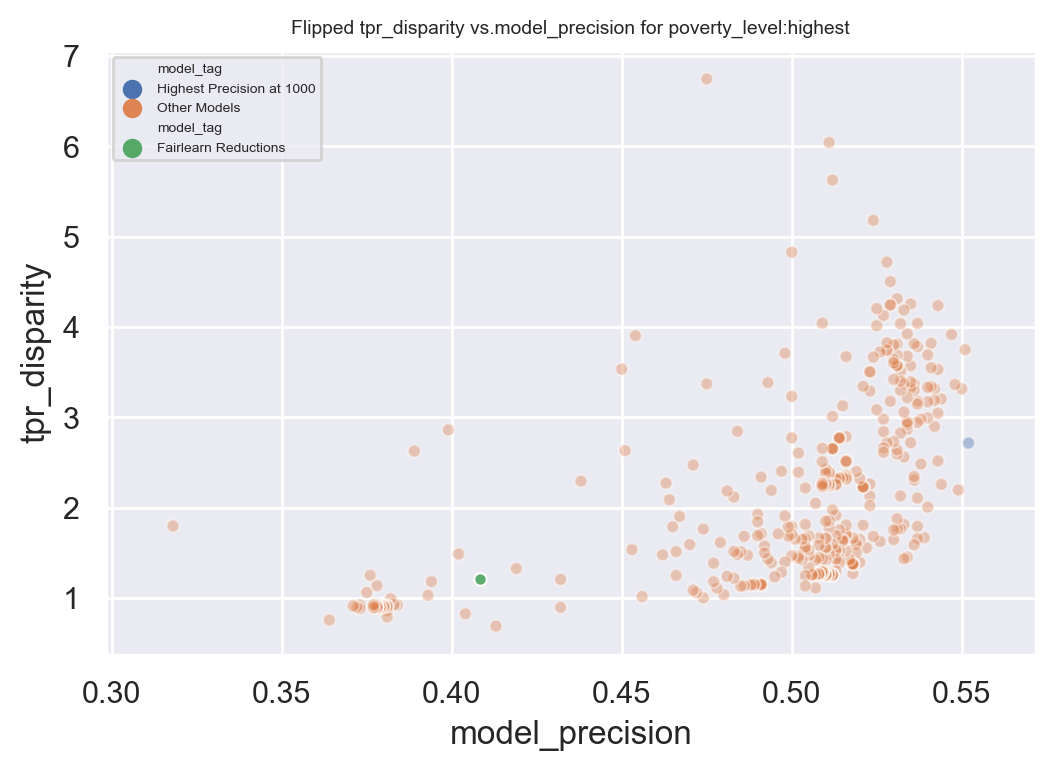

In [42]:
#Finally, let's look at how this new option stacks up against what we plotted in our model selection process
mitigated_precision_4 = df_4.loc[df_4['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':edf, 
    'aequitas_df':adf,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tags':['Fairlearn Reductions'],
    'mitigated_bdfs':[bdf_4], 
    'mitigated_performances':[mitigated_precision_4], 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)


In [ ]:
#NICE TO HAVE ABOVE

In [ ]:
# ALL STEPS BELOW ARE NEEDED

In [44]:
# Step 1. Define the constraint
constraint = TruePositiveRateDifference()

# Step 2. Define the base estimator (any estimator providing 'fit' and 'predict')
# Note: we could have used other algorithm such as logistic regression or random forest
#base_estimator = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10)

base_estimator = LogisticRegression()

# Step 3. Define the bias reducer algorithm you want to apply
bias_reducer = ExponentiatedGradient(base_estimator, constraint, T=50)

# Step 4. Fit the data (and provide the sensitive attributes)
bias_reducer.fit(X_train, y_train, sensitive_features=A_train)

In [45]:
# Step 5. Use the mitigator to make predictions 
y_pred_4 = bias_reducer.predict(X_test)
new_preds_4 = testdf[['entity_id','as_of_date','quickstart_label']].copy()
new_preds_4['score'] = y_pred_4

In [46]:
new_preds_4['score'].value_counts()

0    15912
1     1765
Name: score, dtype: int64

In [47]:
#Load the predictions from the "best" model chosen earlier

old_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
old_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

old_df = pd.merge(old_preds, old_attrdf, how='left', on=[id_col, date_col], left_index=True, right_index=False, sort=True, copy=True)

old_df = old_df.sort_values('predict_proba', ascending=False)
old_df = old_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
old_df['score'] = old_df.apply(lambda x: 1.0 if x.name in old_df.head(top_k).index.tolist() else 0, axis=1)

In [48]:
#Before: Run Aequitas for the "best" model chosen earlier
def aequitas_audit(input_df, ref_groups_dict):
    g = Group()
    b = Bias()
    xtab, _ = g.get_crosstabs(input_df[['score','label_value'] + list(ref_groups_dict.keys())].copy())
    bdf = b.get_disparity_predefined_groups(xtab, input_df, ref_groups_dict)
    return bdf

In [83]:
old_df.shape, X_test.shape

((17677, 8), (17677, 110))

In [82]:
old_df.head(2)

,entity_id,as_of_date,label_value,predict_proba,poverty_level,teacher_sex,metro_type,score
17465,168836,1359504000000,0.0,0.658896,lower,female,suburban_rural,1.0
16725,169208,1359331200000,1.0,0.657936,lower,female,suburban_rural,1.0


In [49]:
bdf_old = aequitas_audit(old_df, protected_attribute_ref_group)

ap.disparity(bdf_old, metrics, attr_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

In [50]:
#After: Run Aequitas for the new, fairness-aware model

df_4 = pd.merge(new_preds_4, test_attrdf, how='left', on=['entity_id','as_of_date'], left_index=True, right_index=False, sort=True, copy=True)
df_4 = df_4.rename(columns = {label_col:'label_value'})

bdf_4 = aequitas_audit(df_4, protected_attribute_ref_group)

ap.disparity(bdf_4, metrics, attr_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

In [25]:
#Precision of best model chosen earlier and new fairness model

print(old_df.loc[old_df['score']==1]['label_value'].mean())
print(df_4.loc[df_4['score']==1]['label_value'].mean())

0.552
0.4083066116964422


In [ ]:
## REF CODE BELOW - NOT NEEDED

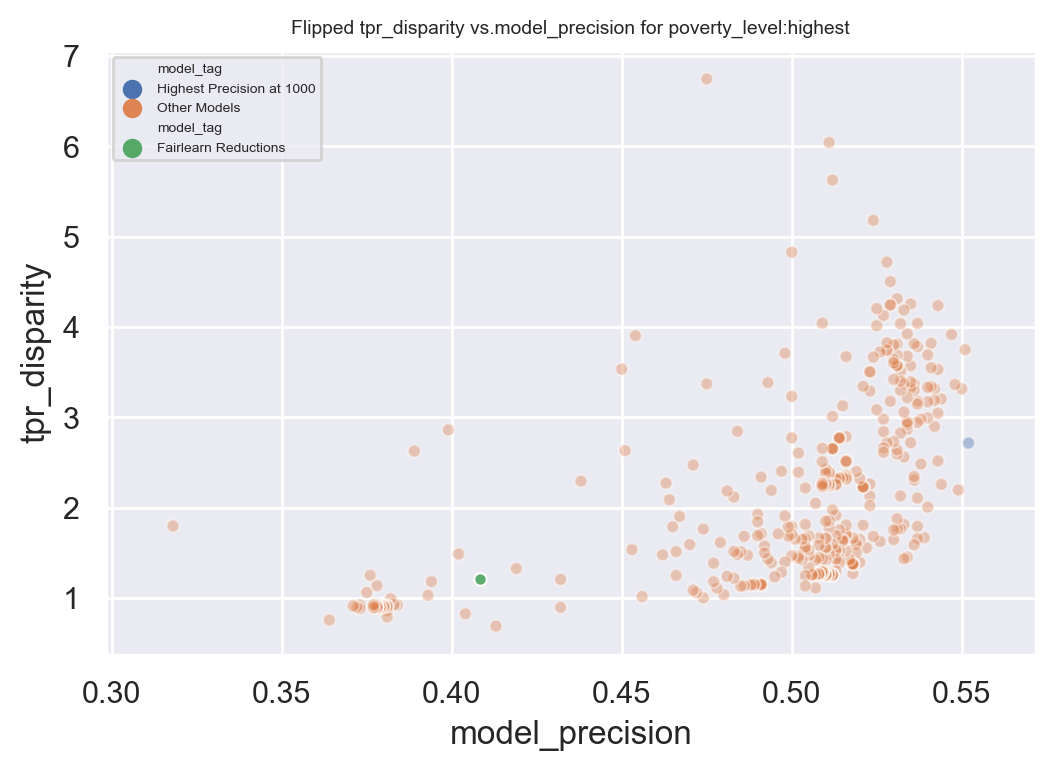

In [37]:
#Finally, let's look at how this new option stacks up against what we plotted in our model selection process
mitigated_precision_4 = df_4.loc[df_4['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tags':['Fairlearn Reductions'],
    'mitigated_bdfs':[bdf_4], 
    'mitigated_performances':[mitigated_precision_4], 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)